##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Compare GAN models Colab

This Colab notebook shows how to use a collection of pre-trained generative adversarial network models (GANs) for CIFAR10, CelebA HQ (128x128) and LSUN bedroom datasets to generate images. Random vectors are fed into the latent space to generate RGB images using the pre-trained generators.

For the details of the setup, please refer to our paper: [The GAN Landscape: Losses, Architectures, Regularization, and Normalization](https://arxiv.org/abs/1807.04720).

The code used to train these models is available at: https://github.com/google/compare_gan

These models are available as [TensorFlow Hub Modules](https://tfhub.dev).

<table align="left">
<td>
  <a target="_blank"  href="https://github.com/google/compare_gan/blob/master/compare_gan/src/tfhub_models.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View notebook source on GitHub</a>
</td></table>

## View the available GAN modules

Run the cells and select the GAN module to use from the table below.

Se importan distintas funciones que luego usará el código principal. Estas funciones hacen el código más interactivo y perimiten seleccionar distintas arquitecturas GAN

Realizo un pequeño cambio al código para poder numerar los casos

In [0]:
#@title Imports, set up, and helper functions

from google.colab import output

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub


tf.logging.set_verbosity(tf.logging.ERROR)



# Get the module metadata for the GANs as a pandas DataFrame.
# Añado al diccionario 'caso':list(range(1,16))
module_metadata_dict = {'caso':list(range(1,16)),'dataset': ['CelebA HQ (128x128)', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'LSUN Bedroom', 'CelebA HQ (128x128)', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'LSUN Bedroom', 'CelebA HQ (128x128)', 'LSUN Bedroom', 'CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10', 'CIFAR10'], 'penalty': ['-', '-', '-', '-', '-', '-', '-', '-', 'DRAGAN (lambda=1.000)', 'WGAN (lambda=0.145)', '-', '-', '-', '-', 'WGAN (lambda=1.000)'], 'architecture': ['ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet19', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR', 'ResNet CIFAR'], 'beta1': ['0.375', '0.500', '0.585', '0.195', '0.500', '0.500', '0.500', '0.102', '0.500', '0.711', '0.500', '0.500', '0.500', '0.500', '0.500'], 'beta2': ['0.998', '0.999', '0.990', '0.882', '0.999', '0.999', '0.999', '0.998', '0.900', '0.979', '0.999', '0.999', '0.999', '0.999', '0.999'], 'module_url': ['https://tfhub.dev/google/compare_gan/model_1_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_2_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_3_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_4_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_5_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_6_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_7_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_8_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_9_celebahq128_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_10_lsun_bedroom_resnet19/1', 'https://tfhub.dev/google/compare_gan/model_11_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_12_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_13_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_14_cifar10_resnet_cifar/1', 'https://tfhub.dev/google/compare_gan/model_15_cifar10_resnet_cifar/1'], 'disc_iters': [1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 5, 5, 5, 5], 'model': ['Non-saturating GAN', 'Non-saturating GAN', 'Least-squares GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Least-squares GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN', 'Non-saturating GAN'], 'inception_score': ['2.38', '2.59', '4.23', '4.10', '2.38', '2.54', '3.64', '3.58', '2.34', '3.92', '7.57', '7.47', '7.74', '7.74', '7.70'], 'disc_norm': ['none', 'none', 'none', 'none', 'layer_norm', 'layer_norm', 'spectral_norm', 'spectral_norm', 'layer_norm', 'layer_norm', 'none', 'none', 'spectral_norm', 'spectral_norm', 'spectral_norm'], 'fid': ['34.29', '35.85', '102.74', '112.92', '30.02', '32.05', '41.60', '42.51', '29.13', '40.36', '28.12', '30.08', '22.91', '23.22', '22.73'], 'ms_ssim_score': ['0.32', '0.29', 'N/A', 'N/A', '0.29', '0.28', 'N/A', 'N/A', '0.30', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A'], 'learning_rate': ['3.381e-05', '1.000e-04', '3.220e-05', '1.927e-05', '1.000e-04', '1.000e-04', '2.000e-04', '2.851e-04', '1.000e-04', '1.281e-04', '2.000e-04', '1.000e-04', '2.000e-04', '2.000e-04', '2.000e-04']}
MODULE_METADATA = pd.DataFrame.from_dict(module_metadata_dict)

# To start, select the module with the lowest FID score.
MIN_FID_MODULE = MODULE_METADATA.loc[
    MODULE_METADATA['fid'].astype(float).idxmin()]

SELECTED_MODULE = MIN_FID_MODULE['module_url']
SELECTED_MODULE_DATASET = MIN_FID_MODULE['dataset']


# Display multiple images in the same figure.
def display_images(images, captions=None):
  batch_size, dim1, dim2, channels = images.shape
  num_horizontally = 8
  
  # Use a smaller figure size for the CIFAR10 images
  figsize = (20, 20) if dim1 > 32 else (10, 10)
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=figsize)
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()
  

# Show the HTML for the module table
class ShowModuleTable(object):
  def __init__(self, callback):
    self._callback = callback

  def _repr_html_(self):
    # Set up the template with some nice CSS.
    template = """
    <style>
       table {
         font-size: 15px;
         font-family: Inconsolata, monospace;
         border-collapse: collapse;
         border: 1px solid #444444;
       }
       th {
         font-size: 18px;
         background-color: #DDDDDD;
         border: 1px solid #AAAAAA;
         white-space: nowrap;
       }
       tr {
         cursor: pointer;
         white-space: nowrap;
       }
       td {
         padding: 6px 6px 6px 6px;
         border: 1px solid #AAAAAA;
       }
      .selected-row {
        font-weight: bold;
        background-color: #B0BED9;
      }
    </style>
    <table>"""
    
    # Set up the headers with nicely readable names
    # añado: ('caso','Caso')
    table_headers = [
      ('caso','Caso')  ,
      ('dataset', 'Dataset'),
      ('architecture', 'Architecture'),
      ('fid', 'FID'),
      ('inception_score', 'IS'),
      ('ms_ssim_score', 'MS-SSIM'),
      ('model', 'Model'),
      ('learning_rate', 'Learning rate'),
      ('beta1', '&beta;<sub>1</sub>'),
      ('beta2', '&beta;<sub>2</sub>'),
      ('disc_iters', 'n<sub>disc</sub>'),
      ('disc_norm', 'Disc norm'),
      ('penalty', 'Penalty'),
      ('module_url', 'Module name'),
    ]
    header_template = "<tr>"
    for _, header_name in table_headers:
      header_template += "<th>" + header_name + "</th>"
    header_template += "</tr>"
    template += header_template
    
    for i, (_, row) in enumerate(MODULE_METADATA.iterrows()):
      uuid = "row-%s" % i
      
      # Reister the callback for every row.
      output.register_callback(uuid, self._callback)
      
      # By default select the module with the min FID.
      selected_class = ""
      if row['module_url'] == MIN_FID_MODULE['module_url']:
        selected_class = "class=\"selected-row\""

      # Get the metadata for each row.
      row_template = "<tr id=\"" + uuid + "\"" + selected_class + ">"
      for key, _ in table_headers:
        row_template += "<td>" + str(row[key]) + "</td>"
      row_template += "</tr>"
      template += row_template
      
    # Add the onclick handlers for the table rows.
    template += """
      </table>
      <script>"""
    
    for i, (_, row) in enumerate(MODULE_METADATA.iterrows()):
      uuid = "row-%s" % i
      m = row['module_url']
      d = row['dataset']
      template += """
        document.querySelector(\"#""" + uuid + """\").onclick = function() {
          google.colab.kernel.invokeFunction('""" + uuid + """', ['""" + m +"""', '""" + d + """'], {});
          var selected = document.getElementsByClassName('selected-row');
          for (var i = 0; i < selected.length; i++) {
            selected[i].classList.remove('selected-row');
          }
          this.classList.toggle("selected-row");
          e.preventDefault();
        };
        """
    template += """</script>"""
    return template


def set_selected_module(module_name, dataset):
  # Assign the selected module and dataset to the global variables
  global SELECTED_MODULE
  SELECTED_MODULE = module_name
  global SELECTED_MODULE_DATASET
  SELECTED_MODULE_DATASET = dataset


In [4]:
#@title Run this cell and select which GAN module to use below

ShowModuleTable(set_selected_module)

Caso,Dataset,Architecture,FID,IS,MS-SSIM,Model,Learning rate,β1,β2,ndisc,Disc norm,Penalty,Module name
1,CelebA HQ (128x128),ResNet19,34.29,2.38,0.32,Non-saturating GAN,3.381e-05,0.375,0.998,1,none,-,https://tfhub.dev/google/compare_gan/model_1_celebahq128_resnet19/1
2,CelebA HQ (128x128),ResNet19,35.85,2.59,0.29,Non-saturating GAN,1.000e-04,0.500,0.999,1,none,-,https://tfhub.dev/google/compare_gan/model_2_celebahq128_resnet19/1
3,LSUN Bedroom,ResNet19,102.74,4.23,N/A,Least-squares GAN,3.220e-05,0.585,0.990,1,none,-,https://tfhub.dev/google/compare_gan/model_3_lsun_bedroom_resnet19/1
4,LSUN Bedroom,ResNet19,112.92,4.10,N/A,Non-saturating GAN,1.927e-05,0.195,0.882,1,none,-,https://tfhub.dev/google/compare_gan/model_4_lsun_bedroom_resnet19/1
5,CelebA HQ (128x128),ResNet19,30.02,2.38,0.29,Non-saturating GAN,1.000e-04,0.500,0.999,1,layer_norm,-,https://tfhub.dev/google/compare_gan/model_5_celebahq128_resnet19/1
6,CelebA HQ (128x128),ResNet19,32.05,2.54,0.28,Non-saturating GAN,1.000e-04,0.500,0.999,1,layer_norm,-,https://tfhub.dev/google/compare_gan/model_6_celebahq128_resnet19/1
7,LSUN Bedroom,ResNet19,41.60,3.64,N/A,Least-squares GAN,2.000e-04,0.500,0.999,1,spectral_norm,-,https://tfhub.dev/google/compare_gan/model_7_lsun_bedroom_resnet19/1
8,LSUN Bedroom,ResNet19,42.51,3.58,N/A,Non-saturating GAN,2.851e-04,0.102,0.998,1,spectral_norm,-,https://tfhub.dev/google/compare_gan/model_8_lsun_bedroom_resnet19/1
9,CelebA HQ (128x128),ResNet19,29.13,2.34,0.30,Non-saturating GAN,1.000e-04,0.500,0.900,5,layer_norm,DRAGAN (lambda=1.000),https://tfhub.dev/google/compare_gan/model_9_celebahq128_resnet19/1
10,LSUN Bedroom,ResNet19,40.36,3.92,N/A,Non-saturating GAN,1.281e-04,0.711,0.979,1,layer_norm,WGAN (lambda=0.145),https://tfhub.dev/google/compare_gan/model_10_lsun_bedroom_resnet19/1


## Generate images from the selected module

Using module: "https://tfhub.dev/google/compare_gan/model_15_cifar10_resnet_cifar/1"
Generating images like dataset: "CIFAR10"


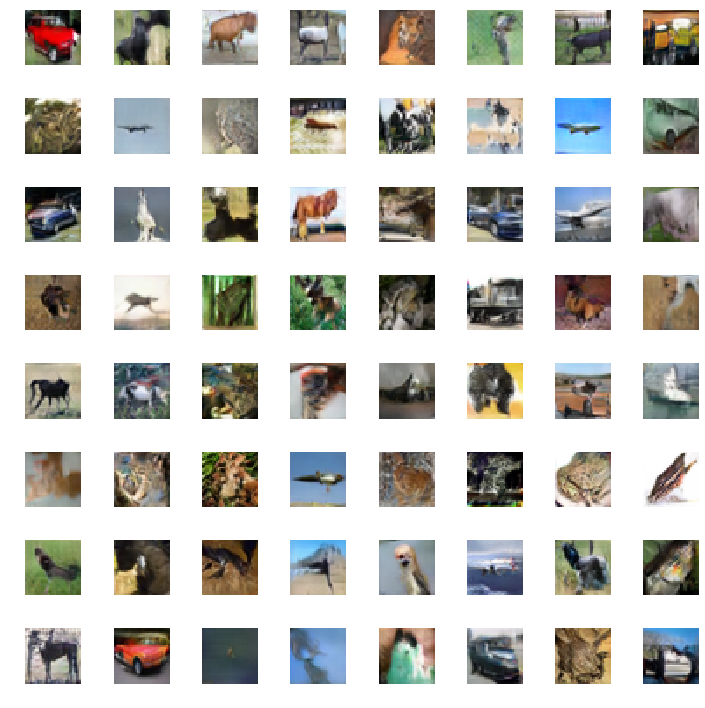

In [5]:
assert SELECTED_MODULE is not None and SELECTED_MODULE_DATASET is not None, \
  'You must run the above cell and select a module from the table to generate images.'

print('Using module: "%s"' % SELECTED_MODULE)
print('Generating images like dataset: "%s"' % SELECTED_MODULE_DATASET)

#Configura por defecto el tamaño del batch y las dimensiones de la imagen
# The generator expects a batch of 64 vectors of size 128
batch_size = 64
z_dim = 128

with tf.Graph().as_default():
  # Load the selected module
  gan = hub.Module(SELECTED_MODULE)
  z_input = tf.placeholder(dtype=tf.float32, shape=(batch_size, z_dim))
  image_output = gan(z_input, signature="generator") 
  
  with tf.train.MonitoredSession() as session:
    # Generate 64 random vectors as input to the latent space to generate images
    z_values = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    images = session.run(image_output, feed_dict={z_input: z_values})

    # View the resulting images
    display_images(images)

### Comentarios:

* https://arxiv.org/pdf/1711.10337.pdf
* https://arxiv.org/pdf/1807.04720.pdf

Las arquitecturas utlizadas están basadas en la ResNet19:

![texto alternativo](https://file.ai100.com.cn/files/articles-other/original/7ce344ff-fb92-4b5f-907a-f97974cedaf3/640.png)

Voy a comentar alguna de los casos de la tabla de modelos y datos

Caso 1 CelebA HQ (128x128): interesante como genera caras de famosos, algunos híbridos son reconocibles... pero parecen sacados de una película de terror!!

Caso 6 CelebA HQ (128x128):  el introducir normalización en el módulo de normalización parece que mejora y las caras parece más humanas

Caso 9 CelebA HQ (128x128):  el introducir penalización parece que no mejora las imágenes (a mi me parecen "zombis")

Tengo la sensación que el usar fotos sin eliminar el fondo distorsionan la calidad real del modelo

Ahora miraré un par de casos usando LSUN Bedroom

Caso 3 LSUN Bedroom: bastante malos resultados si se buscaba realismo, si se buscaba generar imágenes artísticas podría servir.

Caso 8 LSUN Bedroom: parece que el uso de normalizción espectral mejora bastante las imágenes (https://github.com/IShengFang/SpectralNormalizationKeras)
